In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import sentencepiece as spm
import matplotlib.pyplot as plt
import seaborn as sns
torch.manual_seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
import warnings
warnings.filterwarnings("ignore")
device

device(type='cuda')

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!ls "/content/drive/MyDrive"

'Colab Notebooks'   MachineTranslation


In [4]:
import os
# copy the file back to colab from drive

save_dir = "/content/drive/MyDrive/MachineTranslation"

# List files
!ls "{save_dir}"

# Copy files to Colab
!cp "{save_dir}/checkpoint_epoch_12.pt" /content/
!cp "{save_dir}/metrics.json" /content/
!cp "{save_dir}/urdu.model" /content/
!cp "{save_dir}/english.model" /content/


checkpoint_epoch_12.pt	english.model  metrics.json  urdu.model


- Each SentencePiece model built different subword rules.

- So what used to be 200 tokens with tokenizer A might become 600 tokens with tokenizer B.
- SentencePiece is a subword tokenizer.

In [5]:
df = pd.read_csv("merge_data.csv")
df.head()

,input,target
0,How can I communicate with my parents?,میں اپنے والدین سے کیسے بات کروں ؟
1,How can I make friends?’,میں دوست کیسے بنائوں ؟
2,Why do I get so sad?’,میں اتنا اداس کیوں ہوں؟.
3,"If you’ve asked yourself such questions, you’r...",اگر آپ نے اپنے آپ سے ایسے سوالات کیے ہیں، تو آ...
4,"Depending on where you’ve turned for guidance,...",اس بات پر منحصر ہے کہ آپ رہنمائی کے لیے کہاں ...


In [6]:
df.shape

(53638, 2)

In [7]:
with open("english.txt" ,"w",encoding="utf-8") as f:
  for english in df["input"]:
    f.write(str(english) + "\n")

with open("urdu.txt" ,"w",encoding="utf-8") as f:
  for urdu in df["target"]:
    f.write(str(urdu) + "\n")

# Tokenizer
- when we tokenize we need to combine both english urdu into single txt file

In [8]:
# # Englis Tokenizer
# spm.SentencePieceTrainer.train(
#     input="english.txt",
#     model_prefix="english",
#     vocab_size=8000,
#     model_type="bpe",
#     bos_id=1,  # Add BOS token
#     eos_id=2,  # Add EOS token
#     unk_id=0,
#     pad_id=3
# )

# spm.SentencePieceTrainer.train(
#     input="urdu.txt",
#     model_prefix="urdu",
#     vocab_size=8000,
#     model_type="bpe",
#     bos_id=1,
#     eos_id=2,
#     unk_id=0,
#     pad_id=3
# )



In [9]:
# Reload tokenizers
sp_en = spm.SentencePieceProcessor()
sp_en.load("english.model")

sp_ur = spm.SentencePieceProcessor()
sp_ur.load("urdu.model")

# Verify special tokens
print(f"English - BOS: {sp_en.bos_id()}, EOS: {sp_en.eos_id()}, UNK: {sp_en.unk_id()}, PAD: {sp_en.pad_id()}")
print(f"Urdu - BOS: {sp_ur.bos_id()}, EOS: {sp_ur.eos_id()}, UNK: {sp_ur.unk_id()}, PAD: {sp_ur.pad_id()}")

English - BOS: 1, EOS: 2, UNK: 0, PAD: 3
Urdu - BOS: 1, EOS: 2, UNK: 0, PAD: 3


In [10]:
MAX_LEN = 256
df["en_len"] = df["input"].apply(lambda x: len(sp_en.encode(str(x))))
df["ur_len"] = df["target"].apply(lambda x: len(sp_ur.encode(str(x))))

df_clean = df[(df['en_len'] <= MAX_LEN) & (df['ur_len'] <= MAX_LEN)]  # remove sequen6ce greater than 256 tokens
print(f"Original data: {len(df)} samples")
print(f"Filtered data: {len(df_clean)} samples")
print(f"Removed: {len(df) - len(df_clean)} samples")

Original data: 53638 samples
Filtered data: 53619 samples
Removed: 19 samples


# Convert Dataset → Token IDs with Padding

In [11]:
english_sentences = df_clean['input'].tolist()
urdu_sentences = df_clean['target'].tolist()

# Compute max length for each
max_len_en = max(len(sp_en.encode(sent)) for sent in english_sentences if isinstance(sent, str))
max_len_ur = max(len(sp_ur.encode(sent)) for sent in urdu_sentences if isinstance(sent, str))

print("Max English sequence length:", max_len_en)
print("Max Urdu sequence length:", max_len_ur)

max_len = max(max_len_en, max_len_ur)
print("Overall max sequence length:", max_len)

Max English sequence length: 254
Max Urdu sequence length: 256
Overall max sequence length: 256


In [12]:
print(sp_en.get_piece_size(), sp_ur.get_piece_size())

8000 8000


In [13]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    df["input"], df["target"], test_size=0.1, random_state=42
)


In [14]:
import torch
from torch.nn.utils.rnn import pad_sequence

max_len = max_len

bos_id = sp_ur.piece_to_id("<BOS>")   # it get BOS id in SentencePiece and return its ID which is 1
eos_id = sp_ur.piece_to_id("<EOS>")  # it get EOS id in SentencePiece and return its ID which is 2

def encode_sentence(example, sp, max_len, add_bos_eos=False):
    """
    add_bos_eos = if True, BOS (1) and EOS (2) will be added to all the tokens
    """
    tokens = sp.encode(str(example), out_type=int)
    if add_bos_eos:
        bos_id = sp.bos_id()
        eos_id = sp.eos_id()
        tokens = [bos_id] + tokens + [eos_id]
    return torch.tensor(tokens[:max_len], dtype=torch.long)   # [:max_len] ==> truncate the sequence so it doesn’t exceed the maximum length allowed



# encode the text
train_src = [encode_sentence(en, sp_en, max_len, add_bos_eos=False) for en in train_input]
train_tgt = [encode_sentence(urdu, sp_ur, max_len, add_bos_eos=True) for urdu in train_target]

val_src = [encode_sentence(en, sp_en, max_len, add_bos_eos=False) for en in val_input]
val_tgt = [encode_sentence(urdu, sp_ur, max_len, add_bos_eos=True) for urdu in val_target]


In [15]:
x = train_src[1].tolist() # sentence trnsformer expect a Python list of integers, not a PyTorch tensor.
sp_ur.decode(x)

'باترے ج کیدگار باع اپنے کب روکے'

In [16]:
# dataset returns variable-length torch.tensors so we us the below function to make them of same lenght

def collate_fn(batch):
    """
    src_padded = [
      [w1, w2, w3],
      [w1, w2, PAD]]

    src_mask = [
      [1, 1, 1],  # all real tokens
      [1, 1, 0]]   # 0 = PAD token

    it returns:
    input padded + masked
    target padded + masked
    """
    # batch = list of (src, tgt) pairs
    src_batch, tgt_batch = zip(*batch)

    pad_token_id = sp_ur.pad_id()  # use real pad id

    # Pad only to max length of this batch with correct pad id
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=pad_token_id)  # we make sequnce exuall length by adding ==>  PAD (special token)
    tgt_padded = pad_sequence(tgt_batch, batch_first=True, padding_value=pad_token_id)

    # Create masks using pad_token_id (1=real, 0=pad)
      # we check in sec_padded element wise if token equall  0 than  it return True if token is 0 and it  return False if token is not 0
    # Then we convert true false to@
    # True → 1 (real token)
    # False → 0 (padding token
    src_mask = (src_padded != pad_token_id).long()
    tgt_mask = (tgt_padded != pad_token_id).long()

    return src_padded, tgt_padded, src_mask, tgt_mask


# Dataclass

In [17]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn.utils.rnn import pad_sequence

class TranslationDataset(Dataset):
    def __init__(self, src, tgt):
        self.src = src
        self.tgt = tgt

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]  # it returns a tuple


train_dataset = TranslationDataset(train_src, train_tgt)
val_dataset   = TranslationDataset(val_src, val_tgt)


In [18]:
eng,urd = train_dataset[1]
print(eng,urd)
print(sp_en.decode(eng.tolist()))

tensor([ 200,  368,   16,   19, 1164,  905,  117,  294, 4549]) tensor([   1, 1214,   14,  284,   41,  948,   70, 2844,   89,    2])
Owner and Service staff are very courteous


In [19]:
batch = [train_dataset[0], train_dataset[1], train_dataset[2]]
src_padded, tgt_padded, src_mask, tgt_mask = collate_fn(batch)
print(f"{'='*50}Pad_id = 3 {'='*50}")
print("Input(enlgish) padded",src_padded)  # pad_id = 3
print(f"{'='*50}Pad_id = 3 {'='*50}")
print("Target(urdu) padded: ",tgt_padded)
print(f"{'='*50} Masked= 0, orignla = 1 {'='*50}")
print("Input Masked(English): ",src_mask)
print(f"{'='*50} Masked= 0 & original = 1 {'='*50}")
print("Target(Urdu) masked : ",tgt_mask)

==================================================Pad_id = 3 ==================================================
Input(enlgish) padded tensor([[ 342,   57, 1017, 5266,  336,  696, 6040,  949, 2261,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3],
        [ 200,  368,   16,   19, 1164,  905,  117,  294, 4549,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3],
        [ 318,  438,   57, 1555, 2361,  257,  438,  216, 2823,   30,  395,  203,
         1373,  168,   19,   71,  984,  258,   66,   71,  124,    7, 1714,   28,
          286,   39]])
==================================================Pad_id = 3 ==================================================
Target(urdu) padded:  tensor([[   1,   64,  623,  618, 6294,  251,  134,  635,   22, 6048,   14, 3096,
          584,    2,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,   

In [20]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)


# Positional Embedding

In [21]:
import math
class SinusoidalPostionalEncoding(nn.Module):
    def __init__(self,max_len,d_model):
        """
        Args:
            max_len (int): maximum sequence length
            d_model (int): embedding dimension
        PE(pos, 2i)   = sin(pos / (10000^(2i/dim)))
        PE(pos, 2i+1) = cos(pos / (10000^(2i/dim)))
        """
        super().__init__()

        # Step 1: Create a matrix to hold positional encodings
        pe = torch.zeros(max_len,d_model) # Create a matrix of shape (max_len,d_model) to store positional encoding

        ## Step 2: Create position indices (0 to max_len-1)
        position = torch.arange(0,max_len,dtype=torch.float).unsqueeze(1)

        ## Step 3: Compute inverse frequencies
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:,0::2] = torch.sin(position * div_term)  # even term for sine
        pe[:,1::2] = torch.cos(position * div_term)  # odd term for cos

        # Step 5: Add batch dimension for broadcasting
        pe = pe.unsqueeze(0)  # shape: [1, max_len, dim]

        # Register buffer so it's not a parameter (not trainable)
        self.register_buffer("pe",pe)  # (1,max_len,d_model)   # 1 is batch_dim placeholder for later brodcasting

    def forward(self,x):
      B,T,C = x.shape
      # Add positional encoding to embeddings
      return x + self.pe[:, :T, :]   # add x(input) + positional emnedding


In [22]:
# max_len = 100
# d_model = 64

# pos_enc = SinusoidalPostionalEncoding(max_len, d_model)
# # Dummy input (B,T,C)
# x = torch.zeros(1, max_len, d_model)
# pos_encoding = pos_enc(x).cpu().detach()  # (T,C)

# # Plot
# plt.figure(figsize=(10, 6))
# plt.imshow(pos_encoding.squeeze(0), cmap='viridis') #(T,C)
# plt.xlabel("Embedding Dimension")
# plt.ylabel("Position")
# plt.title("Sinusoidal Positional Encoding")
# plt.colorbar()
# plt.show()

# CrossAttention + SelfAttetnion  with Padding

In [23]:
class MultiHeadAttention(nn.Module):
  """
  self atttenion with 3 features:
  - cross attetnion
  - multi head attetnion
  - multi head attetnion with masking
  """

  def __init__(self,d_model,n_heads,dropout,trace_shapes):
    super().__init__()
    assert d_model % n_heads==0,"Error, Embedding dimension must be divisible with head dimension try chosing differnt head no"
    self.d_model = d_model  # Embedding dimesnion
    self.n_head = n_heads  # No of Heads
    self.d_head = d_model // n_heads  # Dimension of each Head

    self.W_q = nn.Linear(d_model,d_model)  # Weight matrix of Query
    self.W_k = nn.Linear(d_model,d_model)  # Weight matrix of Key
    self.W_v = nn.Linear(d_model,d_model)   # Weight matrix of Value
    self.proj = nn.Linear(d_model,d_model)
    self.dropout = nn.Dropout(dropout)

    self.trace_shapes = trace_shapes  # to print shapes

  def forward(self,x,enc_out,mask=None,padding_mask=None):
    """
    - Self-attention: pass x only
    - Cross-attention: pass q, k, v
    - mask attetnion: futures token are masked
    """
    # step 0 : Exptrant shape of encoder output and decoder input
    B,T,C = x.shape
    ## S stands for the sequence length of the encoder output — i.e., how many tokens the encoder processed.(B, S, C)
    S = enc_out.shape[1] if enc_out is not None else T


    # step 1: genertae query, key and value vector using the above linear layers
    if enc_out is None:
      # self attetnion
      Q = self.W_q(x)  # Generate query vector  (B,T,d_model)
      K = self.W_k(x)  # Generate key vector  (B,T,d_model)
      V = self.W_v(x)  # Generate value vector  (B,T,d_model)
    else:
      # cross-attetnion
        Q = self.W_q(x)          # (B, T, d_model) query from decoder hidden state
        K = self.W_k(enc_out)    # (B, S, d_model) key from encoder output
        V = self.W_v(enc_out)    # (B, S, d_model) value from encoder output


    ## step 2 : reshape and split into multipe heads
    if enc_out is None:
      # Reshape
      q = Q.view(B,T,self.n_head,self.d_head)   # (B,T,d_model) ==> (B,T,H,d_head)
      k = K.view(B,T,self.n_head,self.d_head)   # (B,T,d_model) ==> (B,T,H,d_head)
      v = V.view(B,T,self.n_head,self.d_head)   # (B,T,d_model) ==> (B,T,H,d_head)
    else:
      q = Q.view(B, T, self.n_head, self.d_head) # (B,T,d_model) ==> (B,T,H,d_head)  it is from decoder hidden state
      k = K.view(B, S, self.n_head, self.d_head) # (B,S,H,d_head)
      v = V.view(B, S, self.n_head, self.d_head) # (B,S,H,d_head)

    # split in to muliple heads
    q = q.transpose(1,2)  # (B,T,H,d_head)  ==> (B,H,T,d_head)
    k = k.transpose(1,2)  # (B,T,H,d_head)  ==> (B,H,T,d_head)
    v = v.transpose(1,2)  # (B,T,H,d_head)  ==> (B,H,T,d_head)



    # Step 3 : Attetnion score calculation
    # If no masking this will be att_score
    att_score = (q @ k.transpose(-2,-1)) / (self.d_head**0.5) # att_score: (B,H,T,T) for self-attention, (B,H,T,S) for cross-attention


    # print("att_score shape:", att_score.shape)
    # print("padding_mask shape:", padding_mask.shape if padding_mask is not None else None)


    # step 4: Padding and Masking
    # Apply Padding to both Encoder and Decoder
    if padding_mask is not None:
      padding_mask = padding_mask.to(att_score.device)
      # att_score has shape (B, H, T, S) (for cross-attention) or (B, H, T, T) (for self-attention)
      # padding_mask usually has shape (B, S) (1 = keep, 0 = pad)
      # att_score have 4-dimesnion so to make padding broadcastable for att_score we add 2-Dimesnion
      # (B, S) -> (B, 1, 1, S) we add 2 Dimesnion
      padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)  # (B,S) ==> (B,1,1,S)  for cross attention
      att_score = att_score.masked_fill(padding_mask == 0, float('-inf'))


    # Step 5 :Apply causal mask (only for decoder self-attention)
    if mask is not None and enc_out is None:
      casual_mask = torch.tril(torch.ones(T,T,device=x.device,dtype=torch.bool)).view(1,1,T,T)
      att_score = att_score.masked_fill(casual_mask==0,float('-inf'))


    # step 4 :weighted sum with values
    att_weight = F.softmax(att_score,dim=-1)
    att_weight = self.dropout(att_weight)  # applied dropout
    out = att_weight @ v  ## (B,H,T,d_head)


    # step 5 : concatenate the each Heads output
    concatentaed_output = out.transpose(1,2)   # (B,H,T,h_dim) ==> (B,T,H,d_head)
    # This ensures the tensor is stored contiguously in memory after a transpose. as transpose break memory allocation in pytorch and view can not work if tensor is not contigious.
    concatentaed_output = concatentaed_output.contiguous()  #(B,T,H,d_head)
    # C = H * head_dim  .view simply muliply the last 2 dimension to make them one dimesnion(C)
    concatentaed_output = concatentaed_output.view(B,T,C)


    # step 5: final layer projection
    out = self.proj(concatentaed_output)  ## (B, T, d_model)

    return out


# LayerNorm

In [24]:
class LayerNorm(nn.Module):
  """
  RMSNorm(Root Mean Square LayerNormalization)
  y = x/RMS(X)  where RMS  is RMS = sqrt(eps + mean(x**2))
  """
  def __init__(self,dim,eps=1e-12):
    super().__init__()
    self.eps =eps
    self.weight = nn.Parameter(torch.ones(dim))  # trainable parameter(gamma)

  def forward(self,x):
    # Compute RMS over the last dimension
    # As we take mean over last dimesion after mean it is removed so we keepdim=True so dimesion is not removed after mean
    rms = torch.sqrt(torch.mean(x**2,dim=-1,keepdim=True) + self.eps)
    rms_norm = x / rms
    return self.weight * rms_norm


## Activation function(SWiGLU)

In [25]:
class SwiGLU(nn.Module):
  """
	SwiGLU Activation Block
	Formula:
	  swish(x) = x * sigmoid(B * x)
	  SwiGLU(x) = (xW1) * swish(xW2)
	  output = Dropout( (xW1 * swish(xW2)) W3 )

	  dim = dimension of embedding
	  mult = multiply
	  inner = hidden layer

	  x ──► W1 ─────────────|
							element-wise multiply ──► W3 ──► output
	  x ──► W2 ──► Swish ──┘

  """
  def __init__(self,dim,dropout=0.2,mult=4):
    super().__init__()
    inner = dim * mult
    self.w1 = nn.Linear(dim,inner,bias=False)  # Main path
    self.w2 = nn.Linear(dim,inner,bias=False)  # gate path
    self.w3 = nn.Linear(inner,dim,bias=False)  # projection back to orignal dim
    self.dropout = nn.Dropout(dropout)
    self.swish = nn.SiLU()

  def forward(self,x):
    x1 = self.w1(x)   ## (batch, seq, inner)
    x2 = self.swish(self.w2(x))
    gate_output = x1 * x2  # element-wise gated combination
    out = self.w3(gate_output)
    return self.dropout(out)



# FeedForwardNeuralNetwork(FFN)

In [26]:
class FFN(nn.Module):
  def __init__(self,d_model):
    super().__init__()
    inner = 4*d_model
    self.network = nn.Sequential(
        nn.Linear(d_model,inner),    # expand the input dimesnion
        nn.GELU(),  # to apply non linearity
        nn.Linear(inner,d_model)  # project back to orignal dimesnion
                            )
  def forward(self,x):
    return self.network(x)

# class FFN(nn.Module):
#   def __init__(self,d_model):
#     super().__init__()
#     inner = 4*d_model
#     self.network = nn.Sequential(SwiGLU(d_model))

#   def forward(self,x):
#     return self.network(x)


# Encoder Block

In [27]:
class Encoder(nn.Module):
  def __init__(self,d_model,n_heads,dropout,trace_shapes=False):
    super().__init__()
    self.multi_head_att = MultiHeadAttention(d_model,n_heads,dropout,trace_shapes) #Multi head attetnion
    self.ffn = FFN(d_model)
    self.norm1 = LayerNorm(d_model)
    self.norm2 = LayerNorm(d_model)

    self.dropout = nn.Dropout(dropout)

  def forward(self,x,enc_padding_mask=None,mask=None):
    # Pre-Norm + addtition + dropout
    # step 1: Multi head attetnion
    attn_out = self.multi_head_att(self.norm1(x),
                                   enc_out=None,
                                   mask=mask,
                                   padding_mask=enc_padding_mask)  # apply layer norm before applying multi head attetnion
    x = x + self.dropout(attn_out)

    # Step 2 FFNN
    ffn_out = self.ffn(self.norm2(x))
    x = x + self.dropout(ffn_out)
    return x

# test it
n_heads = 4
d_model = 12
dropout=0.2
padding_mask = torch.tensor([[1, 1, 0, 0]])  # last 2 positions are padding
x = torch.rand(1,4,d_model)  #(B,T,C)
encoder = Encoder(d_model,n_heads,dropout)
out = encoder(x,padding_mask)
print(out.shape)

torch.Size([1, 4, 12])


# Decoder Block

In [28]:
class Decoder(nn.Module):
  def __init__(self,d_model,n_heads,dropout,trace_shapes=False):
    super().__init__()
    self.multi_head_att = MultiHeadAttention(d_model,n_heads,dropout,trace_shapes) #Multi head attetnion
    self.cross_att = MultiHeadAttention(d_model, n_heads, dropout, trace_shapes) # cross attention get q from decoder hidden state and k,v from encoder output
    self.ffn = FFN(d_model)
    self.norm1 = LayerNorm(d_model)
    self.norm2 = LayerNorm(d_model)
    self.norm3 = LayerNorm(d_model)

    self.dropout = nn.Dropout(dropout)

  def forward(self,x,enc_out,tgt_padding_mask=None,enc_padding_mask=None,mask=None):
      """
        x: decoder input (B, T , C)
        enc_out: encoder output (B, T, C)

      Cross-attention uses:
        query (Q) → from decoder’s hidden state
        key (K) and value (V) → from encoder output
      """
      # Step 1: Self-attention (mask future tokens + padding)
      att_out = self.multi_head_att(self.norm1(x),
                                    enc_out=None,
                                    mask=mask,
                                    padding_mask=tgt_padding_mask)  # (B,T,C)  we pass tgt_padding_mask
      x = x + self.dropout(att_out)  # multi head attention with masking


      #step 2: Cross-Attention (queries from decoder, keys/values from encoder)(cross attention use encoder padding mask)
      cross_att = self.cross_att(self.norm2(x),
                                 enc_out,
                                 mask=None,
                                 padding_mask=enc_padding_mask)  #we pass enc_padding_mask
      x = x + self.dropout(cross_att)

      # step 3: ffn
      ffn_out = self.ffn(self.norm3(x))
      x = x + self.dropout(ffn_out)

      return x

  # testing
n_heads = 4
d_model = 8
dropout = 0.2

tgt_padding_mask = torch.tensor([[1, 1, 1, 0]])  # last token padded
enc_padding_mask = torch.tensor([[1, 1, 1, 1, 0, 0]])

enc_out = torch.rand(1,6,d_model)  # encoder output  ===>    (B,S,D)
x = torch.rand(1,4,d_model)  # decoder hidden state  ===>  (B,T,C)

decoder = Decoder(d_model,n_heads,dropout)
out = decoder(x,enc_out,tgt_padding_mask,enc_padding_mask)
print("Decoder output shape:", out.shape)

Decoder output shape: torch.Size([1, 4, 8])


# Model
- Encoder: (B, S, C)
- Decoder: (B, T, C)
- Cross-attention: queries from decoder, keys/values from encoder
- Output: (B, T, vocab_size)

In [29]:
class MyModel(nn.Module):
  def __init__(self,d_model,n_heads,dropout,n_layers,max_len,src_vocab_size,tgt_vocab_size):
    super().__init__()
    self.d_model = d_model
    self.max_len = max_len

    # step 1: Token embedding
    self.src_token_emb = nn.Embedding(src_vocab_size, d_model)  # for English
    self.tgt_token_emb = nn.Embedding(tgt_vocab_size, d_model)  # for Urdu

    # Step 2: Postional encoding
    self.pos_enc = SinusoidalPostionalEncoding(max_len,d_model)

    # Step 3: Encoder + Decoder Blocks Stack
    self.encoder_blocks = nn.ModuleList([
        Encoder(d_model,n_heads,dropout)
        for _ in range(n_layers)
    ])
    self.decoder_blocks = nn.ModuleList([
        Decoder(d_model,n_heads,dropout)
        for _ in range(n_layers)
    ])

    # step 4: LayerNorm before final output projection  as we have used pre-norm in encoder and decoder block
    self.layer_norm = LayerNorm(d_model)

    # step 5 :Final Head linear layer
    self.head = nn.Linear(d_model,tgt_vocab_size) # final Linear layer to project the Decoder hidden state to vacab_size logits afterward we apply softmax

    # step 6 : Dropout
    self.dropout = nn.Dropout(dropout)



  def forward(self,idx,target,target_padding_mask=None,enc_padding_mask=None):
    """
    idx: source sequence (English) -> (B, S)
    target: target sequence (Urdu) -> (B, T)
    """
    #============= Encoder Block working =============
    B,S = idx.shape  # encoder input (english) at this point idx is token(int) indices, not embeddings as it will latter be converted to embedding.
    # step 1 : we first embedd the input
    src_embedd = self.src_token_emb(idx)

    #step 2:  we then apply positonal encoding
    src_input = self.pos_enc(src_embedd)  # postional embedding class add the input+positional embedding

    # step 3 we then execute the encoder block
    x = src_input
    for block in self.encoder_blocks:
      x = block(x,
                enc_padding_mask=enc_padding_mask,
                mask=None)
    enc_out = x


    #============= Dncoder Block working =============

    B,T = target.shape  # decoder input (urdu) at this point target is token(int) indices, not embeddings as it will latter be converted to embedding.

    # step 1 : we first embedd the input
    target_embedd = self.tgt_token_emb(target)

    #step 2:  we then apply positonal encoding
    trg_input = self.pos_enc(target_embedd) # postional embedding class add the input+positional embedding


    # step 3 : we then execute the decoder block
    y = trg_input  # Initialize decoder input with embedded target tokens + positional encoding
    for block in self.decoder_blocks:
      # Each decoder block receives the output of the previous block
      # and attends to the encoder output with masks applied
      y = block(x=y,
                enc_out = enc_out,
                tgt_padding_mask=target_padding_mask,
                enc_padding_mask=enc_padding_mask,
                mask=True) # it recieve Mask and enc_padding_mask  and target_padding_mask
    dec_out = y

    #================Final Head for output ========================
    x = self.layer_norm(dec_out)
    logits = self.head(dec_out)

    return logits



In [30]:
from transformers import get_linear_schedule_with_warmup

d_model = 512  # embedding dimesnion
n_heads = 8  # 512/8 ==> 64D per Head
n_layers = 6  # no of encoder decoder block
dropout = 0.25

max_len = max_len  # max lenth of sequences(that model can handle)
src_vocab_size = sp_en.get_piece_size()
tgt_vocab_size = sp_ur.get_piece_size()

model = MyModel(d_model = d_model,
                n_heads = n_heads,
                dropout = dropout,
                n_layers = n_layers,
                max_len = max_len,
                src_vocab_size=src_vocab_size,
                tgt_vocab_size=tgt_vocab_size).to(device)

# torch.compile() is a graph-level compiler that optimizes your model for faster GPU/CPU execution by:
# fusing small operation in single large one so it doesnt use many gpu kernel
# it can make traing slow in start but later fast
model = torch.compile(model)


# def get_lr(step, d_model=512, warmup_steps=4000):
#     step = max(step, 1)
#     return (d_model ** -0.5) * min(step ** -0.5, step * warmup_steps ** -1.5)


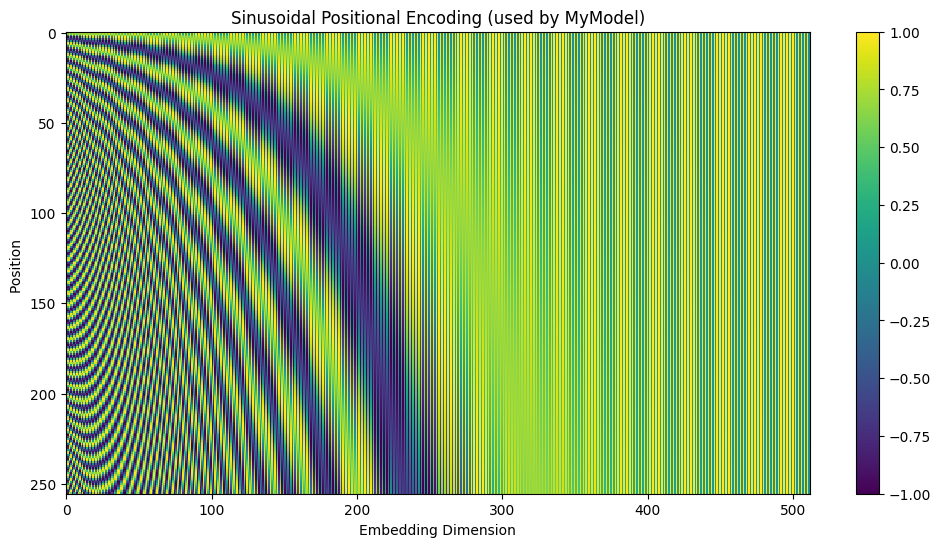

In [31]:
import matplotlib.pyplot as plt

# Get the positional encoding tensor from your trained model
# we extrac pos_encoding from MyModel class Attribute(self.pos_enc) and pe attribute  from postional encoding class
# .detach() this detaches the tensor from the computation graph. mean it stop traking its gradient
#.cpu() we move tensor back to cpu from cuda as we cant plot or convert GPU tensors to NumPy arrays directly as plotting library work with cpu.
pos_encoding = model.pos_enc.pe.squeeze(0).detach().cpu()  # shape: (max_len, d_model)

plt.figure(figsize=(12, 6))
plt.imshow(pos_encoding, cmap='viridis', aspect='auto', interpolation='nearest')
plt.xlabel("Embedding Dimension")
plt.ylabel("Position ")
plt.title("Sinusoidal Positional Encoding (used by MyModel)")
plt.colorbar()
plt.show()

# from the plot we can see that leftmost embedding have very high frequency and as we move across x-axis the frequency decreases
# left most embedding dimesnion : These dimensions capture very fine-grained, local position information.
# right most embedding dimension: These dimensions capture global, coarse-grained position information.

# Model Parameters

In [32]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params:,}")

Total Trainable Parameters: 56,419,648


In [ ]:
# for name, param in model.named_parameters():
#     print(f"{name:40s} | {param.numel():,} params | Trainable: {param.requires_grad}")

In [ ]:
print(torch.cuda.memory_allocated() / 1e9)  # in GB
print(torch.cuda.memory_reserved() / 1e9)   # in GB

In [39]:
import logging

logging.basicConfig(
    filename='training_logs.txt',   # File where logs will be saved
    filemode='a',                   # 'w' to overwrite, 'a' to append
    format='%(asctime)s - %(message)s',
    level=logging.INFO
)


# Training Pipline
- Given all previous words, predict the next one

# Belu intraining

In [33]:
import tqdm as tqdm

@torch.no_grad()
def loss_calculation(val_loader):
    model.eval()
    losses = {}
    pad_token_id = sp_ur.pad_id()

    for split, loader in [("val", val_loader)]:
        split_losses = []
        for xb, yb, src_mask, tgt_mask in tqdm(loader,desc=f"Calculating loss for {split}"):
            xb, yb = xb.to(device), yb.to(device)
            src_mask, tgt_mask = src_mask.to(device), tgt_mask.to(device)

            # Apply shifting
            decoder_input = yb[:, :-1]
            target_output = yb[:, 1:]
            tgt_mask_shifted = tgt_mask[:, :-1]

            logits = model(
                idx=xb,
                target=decoder_input,
                target_padding_mask=tgt_mask_shifted,
                enc_padding_mask=src_mask)


            # Calculate loss
            B, T, C = logits.shape
            logits_flat = logits.reshape(-1, C)  # cross entropy take (B*T,C)
            target_flat = target_output.reshape(-1) # it is not contigous
            loss = F.cross_entropy(logits_flat, target_flat, ignore_index=pad_token_id)  # padding will be ignored during loss calculation   as it make loss unrealistic vers small
            split_losses.append(loss.item())

        losses[split] = sum(split_losses) / len(split_losses)

    return losses

In [34]:
!pip install -qq sacrebleu bitsandbytes

def translate_sentence(sentence,model,sp_en,sp_ur,max_len):
  model.eval()

  # Encode input
  src_token = sp_en.encode(sentence,out_type=int)  # encode the english sentence
  src = torch.tensor(src_token,dtype=torch.long).unsqueeze(0).to(device)
  src_mask = torch.ones_like(src).to(device)  #creates a tensor of all ones with the same shape as src. There’s no padding yet because you have only one sentence, so all tokens are valid.

  bos_id = sp_ur.bos_id()  #begining of sequence id
  eos_id = sp_ur.eos_id()  # end of sequence id
  pad_id = sp_ur.pad_id()  # padding id



  # start with begining of sequnece as output
  tgt = torch.tensor([[bos_id]],dtype=torch.long).to(device)
  generated_token = [] #store the generated token in list

  with torch.no_grad():
    for i in range(max_len):
      tgt_mask = torch.ones_like(tgt).to(device)
      logits = model(
              idx=src,
              target=tgt,
              target_padding_mask=tgt_mask,
              enc_padding_mask=src_mask)
      if torch.isnan(logits).any():  # if their is nan in logits
        break

      # Get next token after bos
      next_token_logit = logits[:,-1,:] # get the alst new generated token
      probs = F.softmax(next_token_logit,dim=-1)


      next_token = torch.argmax(probs,dim=-1,keepdim=True)
      next_token_id = next_token.item()

      generated_token.append(next_token_id)

      # if the next token is eos we break the loop
      if next_token_id == eos_id:
        break
      tgt = torch.cat([tgt,next_token],dim=1)


  # Remove special tokens(eos,bos,bos_id,,pad_id)
  pred_token = [t for t in generated_token if t not in [bos_id, eos_id, pad_id, 0]]

  if len(pred_token) ==0:
    return "Nothing Generated"

  translation = sp_ur.decode(pred_token) # conver token to urdu
  return translation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 14.8 MB/s eta 0:00:00


## Lerning rate schedule
Start small → to avoid exploding gradients

Increase gradually (warmup) → so model begins to learn

Decrease slowly (decay) → for fine convergence at the end

In [ ]:
from tqdm import tqdm
from sacrebleu import corpus_bleu
import time
import json


#==================== List to store values ===============
time_per_epoch = [] #store time taken by epochs
bleu_scores = []  #store belu scores
train_losses = [] #store train loso
val_losses = []  #store val loss
lr_scheduler = [] #store all lerning rates


# =========================Some Parameters =====================
eval_interval = 1  # eval once per epoch
accum_steps = 4
epochs = 4
pad_token_id = sp_ur.pad_id()  # get padding id for target tokens



#================= Learning rate schedule ==========================
learning_rate = 1e-4
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=0.01)
# LR increases linearly for num_warmup_steps
# Then decreases linearly to 0 till training ends.
num_training_steps = len(train_loader) * epochs # e.g 1508 * 10 ==> 15080 stpes
num_warmup_steps = int(0.1 * num_training_steps)  # (10% warmup)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = num_warmup_steps, # step for increasing learning rate(warmup)
    num_training_steps = num_training_steps # total training stpes after it decrease lr
)


best_bleu = 0.0
#============================= Training Loope ==========================

for epoch in range(epochs):
  model.train()
  optimizer.zero_grad()  # clear gradient
  total_train_loss = 0 # inital training loss
  start_time = time.time()

  for step ,(xb,yb,src_mask,tgt_mask) in enumerate(tqdm(train_loader)): # as collate_fn function return 4 things
      xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
      src_mask, tgt_mask = src_mask.to(device), tgt_mask.to(device)


      # Step 1 : Teacher forcing for Decoder input
      # y = [BOS, w1, w2, EOS, PAD, PAD]
      # decoder_input =  [BOS, w1, w2, EOS, PAD]   length=5    all except the last token(EOS)
      # target_output =  [w1, w2, EOS, PAD, PAD]   length=4   all except the first token(BOS)
      decoder_input = yb[:,:-1]   #(batch_size,seq_len)   Urdu sequence shifted right by one
      target_output = yb[:,1:]   #(batch_size,seq_len)    Urdu token shifted left by one.

      # Original mask: [1, 1, 1, 1, 0, 0]   length = 6
      # Remove last element → [1, 1, 1, 1, 0]  length = 5
      # Now the mask aligns with decoder_input
      # We remove the last token of the mask to align it with the decoder input
      tgt_mask_shifted = tgt_mask[:,:-1]  #padding mask for the decoder input.


      # Step 2: forward Propogation
      logits = model(
            idx=xb, #input sequence (source)
            target=decoder_input, #decoder input sequence (teacher forcing)
            target_padding_mask=tgt_mask_shifted, # padding mask for the decoder input
            enc_padding_mask=src_mask) # padding mask for the encoder input



      #Step 3 calculate loss
      B,T,C = logits.shape
      logits_flat = logits.reshape(-1,C)  # as cross entopy take (B,T,C) ==> (B*T,C)
      target_flat = target_output.reshape(-1)
      loss = F.cross_entropy(logits_flat, target_flat, ignore_index=pad_token_id) # we ignore padding in loss calculation
      loss = loss/accum_steps
      loss.backward()



      #Step 4: Update weights after accumulation
      if (step+1) % accum_steps ==0 or (step+1)==len(train_loader):
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # help in reducing exploding gradient issue by normalizing them
          optimizer.step()
          scheduler.step()  #learning rate scheduler
          lr_scheduler.append(scheduler.get_last_lr()[0])
          optimizer.zero_grad()

      # beacuase we divide the loss by accum_Steps it become 4 time smaller to bring it back to normal scale we multiply by accum_stpes
      total_train_loss = total_train_loss + loss.item() * accum_steps # calculate total loss
  avg_train_loss = total_train_loss/len(train_loader)
  train_losses.append(avg_train_loss)



      #Step 5: Evaluation
  if (epoch + 1) % eval_interval == 0:
      losses = loss_calculation(val_loader)
      # train_losses.append(losses["train"])
      val_losses.append(losses["val"])

      end_time = time.time()  # end time
      epoch_time = end_time - start_time
      time_per_epoch.append(epoch_time)
      print(f"Epoch {epoch+1}: train_loss={avg_train_loss:.4f},val_loss={losses['val']:.4f}")
      logging.info(f"Epoch {epoch+1}: train_loss={avg_train_loss:.4f}, val_loss={losses['val']:.4f}")



      #=================== BELU score calculation(val_data) ===========
      model.eval()
      urdu_predictions,urdu_references = [],[]
      with torch.no_grad():
        for src_batch,tgt_batch,src_mask,tgt_mask in tqdm(val_loader,desc="Evaluation BELU"):
          src_batch,src_mask = src_batch.to(device),src_mask.to(device)

          # Dcode each sentence in the batch so we can pass raw input to our translate sentence as it handle raw sentence
          # we only use 5 inputs per batch to speed up training
          for src,tgt in zip(src_batch[:1],tgt_batch[:1]):
            english_sentences = sp_en.decode(list(src.cpu().tolist()))
            ref_sentences = sp_ur.decode(list(tgt.cpu().tolist()))

            pred_sentences = translate_sentence(english_sentences, model, sp_en, sp_ur, max_len=max_len)
            urdu_predictions.append(pred_sentences)
            urdu_references.append(ref_sentences)

        bleu = corpus_bleu(urdu_predictions, [urdu_references])
        print(f"Epoch {epoch+1}: BLEU score = {bleu.score:.2f}")
        logging.info(f"Epoch {epoch+1}: BLEU score = {bleu.score:.2f}")


      # To save model weith best belu scores
      if bleu.score > best_bleu:
        best_bleu = bleu.score
        torch.save(model.state_dict(), "best_model.pt")
        print(f" New best BLEU: {best_bleu:.2f}, model saved!")
        logging.info(f"New best BLEU: {best_bleu:.2f}, model saved!")

       #===== ============ Save belu to List and also save that list to json file ====================
      # Each epoch, you append(bleu.score) to this list.
      # When you json.dump(bleu_scores, f), you are writing the entire Python list to the JSON file.
      # This means the JSON file always contains a list of all BLEU scores so far, not a list of lists.
      bleu_scores.append(bleu.score)  #belu scores
      # with open("bleu_scores.json", "w") as f:
      #   json.dump(bleu_scores, f)  # it will store as python list inside json as we are saving what is being appended in lis we are saving the list


      # Save losses and metrics to one JSON file so we later load them if we restart the checkpoint
      metrics = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "time_per_epoch": time_per_epoch,
        "bleu_scores": bleu_scores,
        "lr_scheduler": lr_scheduler}
      with open("metrics.json","w") as f:
        json.dump(metrics,f)



      # Save checkpoint
      torch.save({
          'epoch': epoch,  #Keeps track of which epoch you were on when saved
          'model_state_dict': model.state_dict(),  #Stores the model's learned parameters (weights & biases)
          'optimizer_state_dict': optimizer.state_dict(),  # Stores optimizer’s internal state includes learning rates, momentum, Adam’s running averages (m, v), etc.
          'scheduler_state_dict': scheduler.state_dict(),  # save scheduler state
          'loss': loss.item() * accum_steps,}, # Saves the most recent loss value
          f"checkpoint_epoch_{epoch+1}.pt")


Calculating loss for val: 100%|██████████| 168/168 [00:35<00:00,  4.79it/s]


Epoch 1: train_loss=6.6396,val_loss=5.3261


Evaluation BELU: 100%|██████████| 168/168 [00:46<00:00,  3.64it/s]


Epoch 1: BLEU score = 2.11
 New best BLEU: 2.11, model saved!


Calculating loss for val: 100%|██████████| 168/168 [00:18<00:00,  9.13it/s]


Epoch 2: train_loss=4.9327,val_loss=4.4401


Evaluation BELU: 100%|██████████| 168/168 [00:24<00:00,  6.96it/s]


Epoch 2: BLEU score = 5.53
 New best BLEU: 5.53, model saved!


Calculating loss for val: 100%|██████████| 168/168 [00:18<00:00,  9.17it/s]


Epoch 3: train_loss=4.2147,val_loss=3.9591


Evaluation BELU: 100%|██████████| 168/168 [00:26<00:00,  6.43it/s]


Epoch 3: BLEU score = 7.68
 New best BLEU: 7.68, model saved!


Calculating loss for val: 100%|██████████| 168/168 [00:18<00:00,  9.11it/s]


Epoch 4: train_loss=3.7642,val_loss=3.6595


Evaluation BELU: 100%|██████████| 168/168 [00:23<00:00,  7.30it/s]


Epoch 4: BLEU score = 9.99
 New best BLEU: 9.99, model saved!


# Resume after training interrupt(Checkpoint)

In [ ]:
from tqdm import tqdm
from sacrebleu import corpus_bleu
import time
import json

# ================== Load Previous Metris score =============================
with open("metrics.json", "r") as f:
    metrics = json.load(f)

train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
time_per_epoch = metrics["time_per_epoch"]
bleu_scores = metrics["bleu_scores"]
lr_scheduler = metrics["lr_scheduler"]

# ================= Parameter =====================

eval_interval = 1  # eval once per epoch
accum_steps = 4
epochs = 12
pad_token_id = sp_ur.pad_id()  # get padding id for target tokens


#================= Learning rate schedule ==========================
learning_rate = 1e-4
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=0.01)
# LR increases linearly for num_warmup_steps
# Then decreases linearly to 0 till training ends.
num_training_steps = len(train_loader) * epochs # e.g 1508 * 10 ==> 15080 stpes
num_warmup_steps = int(0.1 * num_training_steps)  # (10% warmup)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = num_warmup_steps, # step for increasing learning rate(warmup)
    num_training_steps = num_training_steps # total training stpes after it decrease lr
)


best_bleu = max(metrics["bleu_scores"]) if metrics["bleu_scores"] else 0.0  # load best belu score from metrics.json



# ============================= load State ================================
# step 1 : Load checpoint
# Reload checkpoint
checkpoint = torch.load("/content/checkpoint_epoch_5.pt",map_location=device)  # it will start from epoch 3
# Load model weights
model.load_state_dict(checkpoint['model_state_dict'])
# Load optimizer (only needed if you plan to resume training)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#Load scheduler
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
start_epoch = checkpoint['epoch'] + 1



#============================= Training Loope ==========================

print(f"Resuming training from epoch {start_epoch}/{epochs}")
logging.info(f"Resuming training from epoch {start_epoch}/{epochs}")
for epoch in range(start_epoch,epochs):
  model.train()
  optimizer.zero_grad()  # clear gradient
  total_train_loss = 0 # inital training loss
  start_time = time.time()


  for step ,(xb,yb,src_mask,tgt_mask) in enumerate(tqdm(train_loader)): # as collate_fn function return 4 things
      xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
      src_mask, tgt_mask = src_mask.to(device), tgt_mask.to(device)

      # Step 1 : Teacher forcing for Decoder input
      decoder_input = yb[:,:-1]   #(batch_size,seq_len)   Urdu sequence shifted right by one
      target_output = yb[:,1:]   #(batch_size,seq_len)    Urdu token shifted left by one.
      # Original mask: [1, 1, 1, 1, 0, 0]   length = 6
      tgt_mask_shifted = tgt_mask[:,:-1]  #padding mask for the decoder input.

      # Step 2: forward Propogation
      logits = model(
            idx=xb, #input sequence (source)
            target=decoder_input, #decoder input sequence (teacher forcing)
            target_padding_mask=tgt_mask_shifted, # padding mask for the decoder input
            enc_padding_mask=src_mask) # padding mask for the encoder input

      #Step 3 calculate loss
      B,T,C = logits.shape
      logits_flat = logits.reshape(-1,C)  # as cross entopy take (B,T,C) ==> (B*T,C)
      target_flat = target_output.reshape(-1)
      loss = F.cross_entropy(logits_flat, target_flat, ignore_index=pad_token_id) # we ignore padding in loss calculation
      loss = loss/accum_steps
      loss.backward()

      #Step 4: Update weights after accumulation
      if (step+1) % accum_steps ==0 or (step+1)==len(train_loader):
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # help in reducing exploding gradient issue by normalizing them
          optimizer.step()
          scheduler.step()  #learning rate scheduler
          lr_scheduler.append(scheduler.get_last_lr()[0])
          optimizer.zero_grad()

      total_train_loss = total_train_loss + loss.item() * accum_steps # calculate total loss
  avg_train_loss = total_train_loss/len(train_loader)
  train_losses.append(avg_train_loss)

      #Step 5: Evaluation
  if (epoch + 1) % eval_interval == 0:
      losses = loss_calculation(val_loader)
      # train_losses.append(losses["train"])
      val_losses.append(losses["val"])

      end_time = time.time()  # end time
      epoch_time = end_time - start_time
      time_per_epoch.append(epoch_time)
      print(f"Epoch {epoch+1}: train_loss={avg_train_loss:.4f},val_loss={losses['val']:.4f}")
      logging.info(f"Epoch {epoch+1}: train_loss={avg_train_loss:.4f}, val_loss={losses['val']:.4f}")

      #=================== BELU score calculation(val_data) ===========
      model.eval()
      urdu_predictions,urdu_references = [],[]
      with torch.no_grad():
        for src_batch,tgt_batch,src_mask,tgt_mask in tqdm(val_loader,desc="Evaluation BELU"):
          src_batch,src_mask = src_batch.to(device),src_mask.to(device)

          # Dcode each sentence in the batch so we can pass raw input to our translate sentence as it handle raw sentence
          # we only use 5 inputs per batch to speed up training
          for src,tgt in zip(src_batch[:1],tgt_batch[:1]):
            english_sentences = sp_en.decode(list(src.cpu().tolist()))
            ref_sentences = sp_ur.decode(list(tgt.cpu().tolist()))

            pred_sentences = translate_sentence(english_sentences, model, sp_en, sp_ur, max_len=max_len)
            urdu_predictions.append(pred_sentences)
            urdu_references.append(ref_sentences)

        bleu = corpus_bleu(urdu_predictions, [urdu_references])
        print(f"Epoch {epoch+1}: BLEU score = {bleu.score:.2f}")
        logging.info(f"Epoch {epoch+1}: BLEU score = {bleu.score:.2f}")
        bleu_scores.append(bleu.score)


      # To save model weith best belu scores
      if bleu.score > best_bleu:
        best_bleu = bleu.score
        torch.save(model.state_dict(), "best_model.pt")
        print(f" New best BLEU: {best_bleu:.2f}, model saved!")
        logging.info(f"New best BLEU: {best_bleu:.2f}, model saved!")

       #===== ============ Save Metrics to file ====================

       # Save losses and metrics to one JSON file so we later load them if we restart the checkpoint
      metrics = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "time_per_epoch": time_per_epoch,
        "bleu_scores": bleu_scores,
        "lr_scheduler": lr_scheduler}
      with open("metrics.json","w") as f:
        json.dump(metrics,f)

      # Save checkpoint
      torch.save({
          'epoch': epoch,  #Keeps track of which epoch you were on when saved
          'model_state_dict': model.state_dict(),  #Stores the model's learned parameters (weights & biases)
          'optimizer_state_dict': optimizer.state_dict(),  # Stores optimizer’s internal state includes learning rates, momentum, Adam’s running averages (m, v), etc.
          'scheduler_state_dict': scheduler.state_dict(),  # save scheduler state
          'loss': loss.item() * accum_steps,}, # Saves the most recent loss value
          f"checkpoint_epoch_{epoch+1}.pt")


Resuming training from epoch 5/12


Calculating loss for val: 100%|██████████| 168/168 [00:18<00:00,  9.15it/s]


Epoch 6: train_loss=3.1752,val_loss=3.2967


Evaluation BELU: 100%|██████████| 168/168 [00:23<00:00,  7.14it/s]


Epoch 6: BLEU score = 12.02
 New best BLEU: 12.02, model saved!


Calculating loss for val: 100%|██████████| 168/168 [00:18<00:00,  9.16it/s]


Epoch 7: train_loss=2.9648,val_loss=3.1793


Evaluation BELU: 100%|██████████| 168/168 [00:20<00:00,  8.23it/s]


Epoch 7: BLEU score = 14.17
 New best BLEU: 14.17, model saved!


Calculating loss for val: 100%|██████████| 168/168 [00:18<00:00,  9.17it/s]


Epoch 8: train_loss=2.7880,val_loss=3.0777


Evaluation BELU: 100%|██████████| 168/168 [00:21<00:00,  7.66it/s]


Epoch 8: BLEU score = 15.78
 New best BLEU: 15.78, model saved!


Calculating loss for val: 100%|██████████| 168/168 [00:18<00:00,  9.18it/s]


Epoch 9: train_loss=2.6404,val_loss=3.0057


Evaluation BELU: 100%|██████████| 168/168 [00:23<00:00,  7.11it/s]


Epoch 9: BLEU score = 15.39


Calculating loss for val: 100%|██████████| 168/168 [00:18<00:00,  9.14it/s]


Epoch 10: train_loss=2.5169,val_loss=2.9492


Evaluation BELU: 100%|██████████| 168/168 [00:21<00:00,  7.83it/s]


Epoch 10: BLEU score = 16.63
 New best BLEU: 16.63, model saved!


Calculating loss for val: 100%|██████████| 168/168 [00:18<00:00,  9.18it/s]


Epoch 11: train_loss=2.4118,val_loss=2.8994


Evaluation BELU: 100%|██████████| 168/168 [00:22<00:00,  7.49it/s]


Epoch 11: BLEU score = 16.25


Calculating loss for val: 100%|██████████| 168/168 [00:18<00:00,  9.08it/s]


Epoch 12: train_loss=2.3227,val_loss=2.8649


Evaluation BELU: 100%|██████████| 168/168 [00:21<00:00,  7.75it/s]


Epoch 12: BLEU score = 18.22
 New best BLEU: 18.22, model saved!


In [ ]:
from tqdm import tqdm
from sacrebleu import corpus_bleu
import time
import json

# ================== Load Previous Metris score =============================
with open("metrics.json", "r") as f:
    metrics = json.load(f)

train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
time_per_epoch = metrics["time_per_epoch"]
bleu_scores = metrics["bleu_scores"]
lr_scheduler = metrics["lr_scheduler"]

# ================= Parameter =====================

eval_interval = 1  # eval once per epoch
accum_steps = 4
epochs = 20
pad_token_id = sp_ur.pad_id()  # get padding id for target tokens


#================= Learning rate schedule ==========================
learning_rate = 1e-4
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=0.01)
# LR increases linearly for num_warmup_steps
# Then decreases linearly to 0 till training ends.
num_training_steps = len(train_loader) * epochs # e.g 1508 * 10 ==> 15080 stpes
num_warmup_steps = int(0.1 * num_training_steps)  # (10% warmup)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = num_warmup_steps, # step for increasing learning rate(warmup)
    num_training_steps = num_training_steps # total training stpes after it decrease lr
)


best_bleu = max(metrics["bleu_scores"]) if metrics["bleu_scores"] else 0.0  # load best belu score from metrics.json




# ============================= load State ================================
# step 1 : Load checpoint
# Reload checkpoint
checkpoint = torch.load("/content/checkpoint_epoch_12.pt",map_location=device)  # it will start from epoch 12
# Load model weights
model.load_state_dict(checkpoint['model_state_dict'])
# Load optimizer (only needed if you plan to resume training)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#Load scheduler
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
start_epoch = checkpoint['epoch'] + 1



#============================= Training Loop ====================

print(f"Resuming training from epoch {start_epoch}/{epochs}")
for epoch in range(start_epoch,epochs):
  model.train()
  optimizer.zero_grad()  # clear gradient
  total_train_loss = 0 # inital training loss
  start_time = time.time()


  for step ,(xb,yb,src_mask,tgt_mask) in enumerate(tqdm(train_loader)): # as collate_fn function return 4 things
      xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
      src_mask, tgt_mask = src_mask.to(device), tgt_mask.to(device)

      # Step 1 : Teacher forcing for Decoder input
      decoder_input = yb[:,:-1]   #(batch_size,seq_len)   Urdu sequence shifted right by one
      target_output = yb[:,1:]   #(batch_size,seq_len)    Urdu token shifted left by one.
      # Original mask: [1, 1, 1, 1, 0, 0]   length = 6
      tgt_mask_shifted = tgt_mask[:,:-1]  #padding mask for the decoder input.

      # Step 2: forward Propogation
      logits = model(
            idx=xb, #input sequence (source)
            target=decoder_input, #decoder input sequence (teacher forcing)
            target_padding_mask=tgt_mask_shifted, # padding mask for the decoder input
            enc_padding_mask=src_mask) # padding mask for the encoder input

      #Step 3 calculate loss
      B,T,C = logits.shape
      logits_flat = logits.reshape(-1,C)  # as cross entopy take (B,T,C) ==> (B*T,C)
      target_flat = target_output.reshape(-1)
      loss = F.cross_entropy(logits_flat, target_flat, ignore_index=pad_token_id) # we ignore padding in loss calculation
      loss = loss/accum_steps
      loss.backward()

      #Step 4: Update weights after accumulation
      if (step+1) % accum_steps ==0 or (step+1)==len(train_loader):
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # help in reducing exploding gradient issue by normalizing them
          optimizer.step()
          scheduler.step()  #learning rate scheduler
          lr_scheduler.append(scheduler.get_last_lr()[0])
          optimizer.zero_grad()

      total_train_loss = total_train_loss + loss.item() * accum_steps # calculate total loss
  avg_train_loss = total_train_loss/len(train_loader)
  train_losses.append(avg_train_loss)

      #Step 5: Evaluation
  if (epoch + 1) % eval_interval == 0:
      losses = loss_calculation(val_loader)
      # train_losses.append(losses["train"])
      val_losses.append(losses["val"])

      end_time = time.time()  # end time
      epoch_time = end_time - start_time
      time_per_epoch.append(epoch_time)
      print(f"Epoch {epoch+1}: train_loss={avg_train_loss:.4f},val_loss={losses['val']:.4f}")

      #=================== BELU score calculation(val_data) ===========
      model.eval()
      urdu_predictions,urdu_references = [],[]
      with torch.no_grad():
        for src_batch,tgt_batch,src_mask,tgt_mask in tqdm(val_loader,desc="Evaluation BELU"):
          src_batch,src_mask = src_batch.to(device),src_mask.to(device)

          # Dcode each sentence in the batch so we can pass raw input to our translate sentence as it handle raw sentence
          # we only use 5 inputs per batch to speed up training
          for src,tgt in zip(src_batch[:1],tgt_batch[:1]):
            english_sentences = sp_en.decode(list(src.cpu().tolist()))
            ref_sentences = sp_ur.decode(list(tgt.cpu().tolist()))

            pred_sentences = translate_sentence(english_sentences, model, sp_en, sp_ur, max_len=max_len)
            urdu_predictions.append(pred_sentences)
            urdu_references.append(ref_sentences)

        bleu = corpus_bleu(urdu_predictions, [urdu_references])
        print(f"Epoch {epoch+1}: BLEU score = {bleu.score:.2f}")
        bleu_scores.append(bleu.score)


      # To save model weith best belu scores
      if bleu.score > best_bleu:
        best_bleu = bleu.score
        torch.save(model.state_dict(), "best_model.pt")
        print(f" New best BLEU: {best_bleu:.2f}, model saved!")

       #===== ============ Save Metrics to file ====================

       # Save losses and metrics to one JSON file so we later load them if we restart the checkpoint
      metrics = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "time_per_epoch": time_per_epoch,
        "bleu_scores": bleu_scores,
        "lr_scheduler": lr_scheduler}
      with open("metrics.json","w") as f:
        json.dump(metrics,f)

      # Save checkpoint
      torch.save({
          'epoch': epoch,  #Keeps track of which epoch you were on when saved
          'model_state_dict': model.state_dict(),  #Stores the model's learned parameters (weights & biases)
          'optimizer_state_dict': optimizer.state_dict(),  # Stores optimizer’s internal state includes learning rates, momentum, Adam’s running averages (m, v), etc.
          'scheduler_state_dict': scheduler.state_dict(),  # save scheduler state
          'loss': loss.item() * accum_steps,}, # Saves the most recent loss value
          f"checkpoint_epoch_{epoch+1}.pt")


Resuming training from epoch 12/20


Calculating loss for val: 100%|██████████| 168/168 [01:38<00:00,  1.71it/s]


Epoch 13: train_loss=2.3393,val_loss=2.8423


Evaluation BELU: 100%|██████████| 168/168 [01:18<00:00,  2.13it/s]


Epoch 13: BLEU score = 17.54


Calculating loss for val: 100%|██████████| 168/168 [00:18<00:00,  9.04it/s]


Epoch 14: train_loss=2.1688,val_loss=2.7855


Evaluation BELU: 100%|██████████| 168/168 [00:25<00:00,  6.70it/s]


Epoch 14: BLEU score = 17.67


Calculating loss for val: 100%|██████████| 168/168 [00:18<00:00,  8.99it/s]


Epoch 15: train_loss=2.0097,val_loss=2.7312


Evaluation BELU: 100%|██████████| 168/168 [00:23<00:00,  7.11it/s]


Epoch 15: BLEU score = 19.55
 New best BLEU: 19.55, model saved!


Calculating loss for val: 100%|██████████| 168/168 [00:18<00:00,  9.05it/s]


Epoch 16: train_loss=1.8716,val_loss=2.6918


Evaluation BELU: 100%|██████████| 168/168 [00:24<00:00,  6.86it/s]


Epoch 16: BLEU score = 20.26
 New best BLEU: 20.26, model saved!


Calculating loss for val: 100%|██████████| 168/168 [00:18<00:00,  9.07it/s]


Epoch 17: train_loss=1.8462,val_loss=2.6334


Evaluation BELU: 100%|██████████| 168/168 [00:23<00:00,  7.05it/s]


Epoch 17: BLEU score = 20.68
 New best BLEU: 20.68, model saved!


Calculating loss for val: 100%|██████████| 168/168 [00:18<00:00,  9.05it/s]


Epoch 18: train_loss=1.7361,val_loss=2.5936


Evaluation BELU: 100%|██████████| 168/168 [00:22<00:00,  7.44it/s]


Epoch 18: BLEU score = 20.60


Calculating loss for val: 100%|██████████| 168/168 [00:18<00:00,  9.08it/s]


Epoch 19: train_loss=1.6330,val_loss=2.5628


Evaluation BELU: 100%|██████████| 168/168 [00:23<00:00,  7.25it/s]


Epoch 19: BLEU score = 22.48
 New best BLEU: 22.48, model saved!


Calculating loss for val: 100%|██████████| 168/168 [00:18<00:00,  9.00it/s]


Epoch 20: train_loss=1.5371,val_loss=2.5357


Evaluation BELU: 100%|██████████| 168/168 [00:23<00:00,  7.19it/s]


Epoch 20: BLEU score = 22.96
 New best BLEU: 22.96, model saved!


In [46]:
# save file to drive
!mkdir -p /content/drive/MyDrive/MachineTranslation  #create a directery

!cp /content/checkpoint_epoch_20.pt /content/drive/MyDrive/MachineTranslation/
!cp metrics.json /content/drive/MyDrive/MachineTranslation/
!cp /content/urdu.model /content/drive/MyDrive/MachineTranslation/
!cp /content/english.model /content/drive/MyDrive/MachineTranslation/
!cp /content/merge_data.csv /content/drive/MyDrive/MachineTranslation/
!cp /content/best_model.pt /content/drive/MyDrive/MachineTranslation/

# Plots

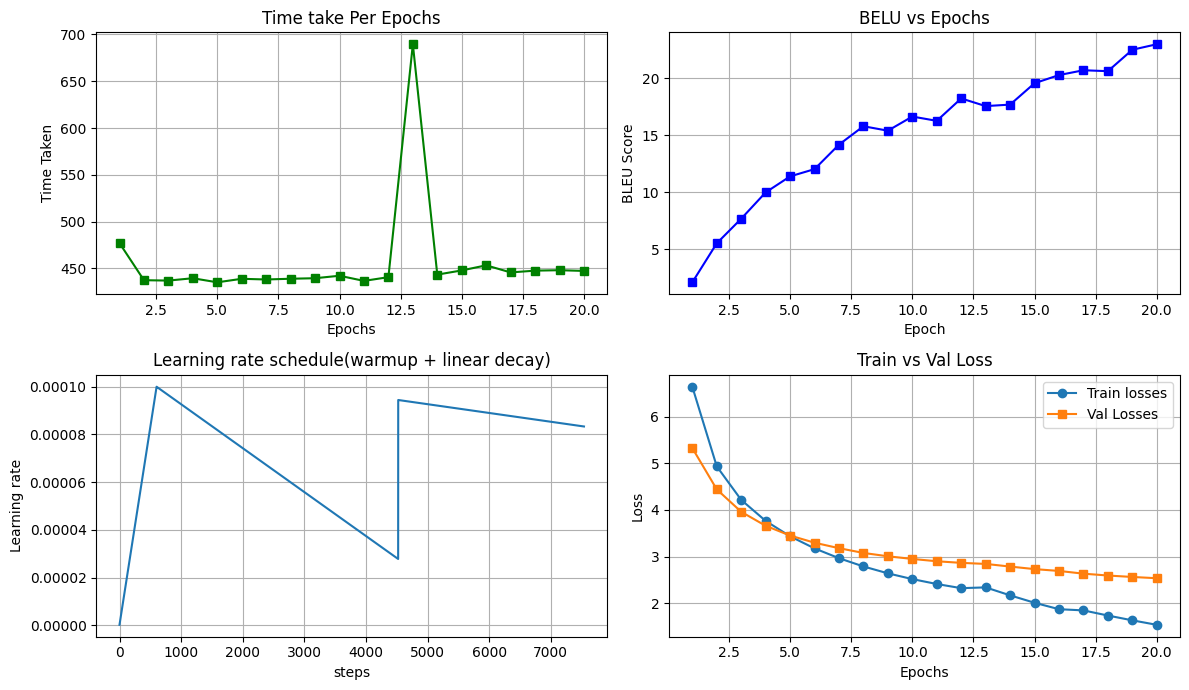

In [40]:
figure,axis = plt.subplots(2,2,figsize=(12,7))
axis = axis.flatten()

epoch_range_time = range(1,len(time_per_epoch)+1)
axis[0].plot(epoch_range_time,time_per_epoch,marker="s",color="green")
axis[0].grid()
axis[0].set_title("Time take Per Epochs")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Time Taken")

# belu score per
x = range(1,len(bleu_scores)+1)
axis[1].plot(x,bleu_scores,marker="s",color="blue")
axis[1].set_title("BELU vs Epochs")
axis[1].set_xlabel("Epoch")
axis[1].set_ylabel("BLEU Score")
axis[1].grid(True)


# learning rate scheduler plot
axis[2].plot(lr_scheduler)
axis[2].set_title("Learning rate schedule(warmup + linear decay)")
axis[2].set_xlabel("steps")
axis[2].set_ylabel("Learning rate")
axis[2].grid()


# train vs val loss over epochs loss plot
epochs_range_train_val = range(1, len(train_losses) + 1) # total loss == total epochs
# epochs_range = range(1,2)
axis[3].plot(epochs_range_train_val,train_losses,label="Train losses",marker = "o")
axis[3].plot(epochs_range_train_val,val_losses,label="Val Losses",marker = "s")
axis[3].set_ylabel("Loss")
axis[3].set_xlabel("Epochs")
axis[3].set_title("Train vs Val Loss")
axis[3].legend()
axis[3].grid()

plt.tight_layout()
plt.show()

## Downlaod file

In [ ]:
from google.colab import files

files.download("/content/checkpoint_epoch_4.pt")

# Inference

In [41]:
def translate_sentence(sentence,model,sp_en,sp_ur,max_len):
  model.eval()

  # Encode input
  src_token = sp_en.encode(sentence,out_type=int)  # encode the english sentence
  src = torch.tensor(src_token,dtype=torch.long).unsqueeze(0).to(device)
  src_mask = torch.ones_like(src).to(device)  #creates a tensor of all ones with the same shape as src. There’s no padding yet because you have only one sentence, so all tokens are valid.

  bos_id = sp_ur.bos_id()  #begining of sequence id
  eos_id = sp_ur.eos_id()  # end of sequence id
  pad_id = sp_ur.pad_id()  # padding id
  print(f"BOS: {bos_id}, EOS: {eos_id}, PAD: {pad_id}")


  # start with begining of sequnece as output
  tgt = torch.tensor([[bos_id]],dtype=torch.long).to(device)
  generated_token = [] #store the generated token in list

  with torch.no_grad():
    for i in range(max_len):
      tgt_mask = torch.ones_like(tgt).to(device)
      logits = model(
              idx=src,
              target=tgt,
              target_padding_mask=tgt_mask,
              enc_padding_mask=src_mask)
      if torch.isnan(logits).any():  # if their is nan in logits
        print(f"Nan at step {i}")
        break

      # Get next token after bos
      next_token_logit = logits[:,-1,:] # get the alst new generated token
      probs = F.softmax(next_token_logit,dim=-1)

      # Debug
      if i < 3:
        top5_probs, top5_ids = torch.topk(probs,k=5)  # we get top 5 probability from the probs for the token to be generated
        print(f"\nstep {i}:")
        for prob,idx in zip(top5_probs[0],top5_ids[0]):
          print(f"{sp_ur.id_to_piece(idx.item())}: {prob.item():.4f}")  # we extract ids and their probability

      next_token = torch.argmax(probs,dim=-1,keepdim=True)
      next_token_id = next_token.item()

      generated_token.append(next_token_id)

      # if the next token is eos we break the loop
      if next_token_id == eos_id:
        print(f"EOS at step {i}")
        break
      tgt = torch.cat([tgt,next_token],dim=1)

  print(f"Generated: {generated_token}")

  # Remove special tokens(eos,bos,bos_id,,pad_id)
  pred_token = [t for t in generated_token if t not in [bos_id, eos_id, pad_id, 0]]

  if len(pred_token) ==0:
    return "Nothing Generated"

  translation = sp_ur.decode(pred_token) # conver token to urdu
  return translation


test_sentences = [
    "How are you?",
    "I love you.",
    "How can I communicate with my parents?	",
    "What is the meaning of this?",
    "Where do you live?",
    "This is very fun."
]

for eng in test_sentences:
    urdu = translate_sentence(eng, model, sp_en, sp_ur, max_len=max_len)
    print(f"\nEN: {eng}")
    print(f"UR: {urdu}")
    print("=" * 50)


BOS: 1, EOS: 2, PAD: 3

step 0:
▁آپ: 0.8831
▁تم: 0.0774
▁کیسے: 0.0130
▁کیا: 0.0050
▁تُم: 0.0023

step 1:
▁کیسی: 0.4399
▁کیسے: 0.2215
▁کتنے: 0.0842
▁کے: 0.0561
▁کی: 0.0466

step 2:
▁ہیں: 0.9851
▁ہے: 0.0055
▁کیسی: 0.0026
▁صف: 0.0013
▁ہیں۔: 0.0008
EOS at step 4
Generated: [114, 3250, 57, 7943, 2]

EN: How are you?
UR: آپ کیسی ہیں؟
BOS: 1, EOS: 2, PAD: 3

step 0:
▁میں: 0.6672
▁مجھے: 0.2317
▁آپ: 0.0526
▁تم: 0.0439
▁مجھ: 0.0023

step 1:
▁آپ: 0.7642
▁تم: 0.1968
▁تمہیں: 0.0342
▁نے: 0.0013
▁آپکو: 0.0010

step 2:
▁سے: 0.9862
▁کو: 0.0077
▁کی: 0.0027
▁کا: 0.0022
▁کے: 0.0006
EOS at step 6
Generated: [29, 114, 28, 1680, 245, 737, 2]

EN: I love you.
UR: میں آپ سے پیار کرتا ہوں۔
BOS: 1, EOS: 2, PAD: 3

step 0:
▁میں: 0.9561
▁مجھے: 0.0121
▁آپ: 0.0086
▁کیسے: 0.0066
▁مجھ: 0.0030

step 1:
▁اپنے: 0.9894
▁اپنی: 0.0043
▁اس: 0.0013
▁نے: 0.0011
▁آپ: 0.0008

step 2:
▁والدین: 0.9996
▁ماں: 0.0001
▁بہن: 0.0000
▁آپ: 0.0000
▁حالات: 0.0000
EOS at step 10
Generated: [29, 117, 1893, 28, 1559, 1559, 412, 609, 157, 7943,

In [44]:
def translate_sentence(sentence,model,sp_en,sp_ur,max_len):
  model.eval()

  # Encode input
  src_token = sp_en.encode(sentence,out_type=int)  # encode the english sentence
  src = torch.tensor(src_token,dtype=torch.long).unsqueeze(0).to(device)
  src_mask = torch.ones_like(src).to(device)  #creates a tensor of all ones with the same shape as src. There’s no padding yet because you have only one sentence, so all tokens are valid.

  bos_id = sp_ur.bos_id()  #begining of sequence id
  eos_id = sp_ur.eos_id()  # end of sequence id
  pad_id = sp_ur.pad_id()  # padding id


  # start with begining of sequnece as output
  tgt = torch.tensor([[bos_id]],dtype=torch.long).to(device)
  generated_token = [] #store the generated token in list

  with torch.no_grad():
    for i in range(max_len):
      tgt_mask = torch.ones_like(tgt).to(device)
      logits = model(
              idx=src,
              target=tgt,
              target_padding_mask=tgt_mask,
              enc_padding_mask=src_mask)
      if torch.isnan(logits).any():  # if their is nan in logits
        break

      # Get next token after bos
      next_token_logit = logits[:,-1,:] # get the alst new generated token
      probs = F.softmax(next_token_logit,dim=-1)


      next_token = torch.argmax(probs,dim=-1,keepdim=True)
      next_token_id = next_token.item()

      generated_token.append(next_token_id)

      # if the next token is eos we break the loop
      if next_token_id == eos_id:
        break
      tgt = torch.cat([tgt,next_token],dim=1)


  # Remove special tokens(eos,bos,bos_id,,pad_id)
  pred_token = [t for t in generated_token if t not in [bos_id, eos_id, pad_id, 0]]

  if len(pred_token) ==0:
    return "Nothing Generated"

  translation = sp_ur.decode(pred_token) # conver token to urdu
  return translation


test_sentences = [
    "How are you?",
    "I love you.",
    "How can I communicate with my parents?	",
    "Where do you live?",
    "This is very fun."
]

for eng in test_sentences:
    urdu = translate_sentence(eng, model, sp_en, sp_ur, max_len=max_len)
    print(f"\nEN: {eng}")
    print(f"UR: {urdu}")
    print("=" * 50)



EN: How are you?
UR: آپ کیسی ہیں؟

EN: I love you.
UR: میں آپ سے پیار کرتا ہوں۔

EN: How can I communicate with my parents?	
UR: میں اپنے والدین سے کیسے کیسے مل سکتا ہوں؟

EN: Where do you live?
UR: آپ کہاں رہتے ہیں؟

EN: This is very fun.
UR: یہ بہت مزے دار ہے۔


### Resume training after interrupt

# Make Prediction After interputing the training to see if model is good or not

In [ ]:
# Reload checkpoint
checkpoint = torch.load("checkpoint_epoch_2.pt",map_location=device)  # it will start from epoch 3

# Load model weights
model.load_state_dict(checkpoint['model_state_dict'])

# Load optimizer (only needed if you plan to resume training)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#set to evaluation
model.eval()

# Translate
eng_sentence = "How are you?"
urdu_translation = translate_sentence(eng, model, sp_en, sp_ur, max_len=max_len)
print("\nEnglish:", eng_sentence)
print("Urdu:", urdu_translation)

# Save model

In [ ]:
# Save only the model weights
torch.save(model.state_dict(), "trained_model.pt")

# Load Model

In [ ]:
# 1. Initialize the model architecture
model = MyModel(d_model = d_model,
                n_heads = n_heads,
                dropout = dropout,
                n_layers = n_layers,
                max_len = max_len,
                src_vocab_size=src_vocab_size,
                tgt_vocab_size=tgt_vocab_size).to(device)

# 2. Load the saved weights
model.load_state_dict(torch.load("trained_model.pt", map_location=device))

# 3. Set the model to evaluation mode (important!)
model.eval()


# BLEU

BLEU 20–35 is decent for such a dataset and setup.

BLEU 35–45 is very good — means your model captures strong translation quality.

BLEU >45 is excellent, achievable only if:

You trained with large vocabularies.

Have good tokenization coverage (no many <unk> tokens).

Model capacity and training duration are high (e.g., 20–30 epochs).

Evaluation BELU scores: 100%|██████████| 50/50 [00:06<00:00,  7.63it/s]



Final BLEU score after 50 sentences: 21.69


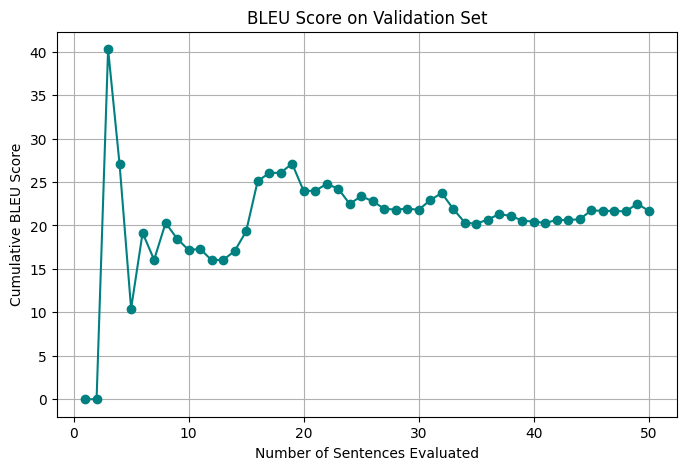

In [48]:
import sacrebleu

sample_size = 50  # number of sentence to be evaluate
urdu_references = []
urdu_predictions = []

bleu_scores = []  # it will have sam no of scores as out sample_size

# decode full validation set from dataloader
val_input = []
val_target = []

# we flattent it i.e we convert the batch in to individuall sequence and convert them to python list as belu require raw sentences(no batch)
for src_batch, tgt_batch, _, _ in val_loader:
    for src, tgt in zip(src_batch, tgt_batch):
        en_sentence = sp_en.decode(list(src.cpu().tolist()))  # move to cpu and convert to python list
        ur_sentence = sp_ur.decode(list(tgt.cpu().tolist()))
        val_input.append(en_sentence)
        val_target.append(ur_sentence)

# using first 50 inputs
for en_sentence, ur_sentence in tqdm(zip(val_input[:sample_size], val_target[:sample_size]),total = sample_size,desc="Evaluation BELU scores"):
    pred_urdu = translate_sentence(en_sentence, model, sp_en, sp_ur, max_len)
    urdu_predictions.append(pred_urdu)
    urdu_references.append(ur_sentence)

    # sacrebleu expects list of lists for references
    bleu = sacrebleu.corpus_bleu(urdu_predictions, [urdu_references])
    bleu_scores.append(bleu.score)

# Print final scores belu
print(f"\nFinal BLEU score after {sample_size} sentences: {bleu_scores[-1]:.2f}")

#plot belu scores
plt.figure(figsize=(8,5))
plt.plot(range(1, len(bleu_scores)+1), bleu_scores, marker='o', color='teal')
plt.xlabel("Number of Sentences Evaluated")
plt.ylabel("Cumulative BLEU Score")
plt.title("BLEU Score on Validation Set")
plt.grid(True)
plt.show()

In [ ]:
# clear gpu memory full clean
import gc
del model,optimizer
gc.collect()
torch.cuda.empty_cache()

print(torch.cuda.memory_summary())

NameError: name 'model' is not defined